# nichefinder — Niche Score Mapping

This notebook demonstrates the different ways of mapping niche models back to
per-cell scores and how to visualise the results.  It builds on the simulated
dataset introduced in the **Simulated Data Tutorial**.

**Parameters explored:**
- **Method**: `"linear"` (dot product) vs `"geometric"` (log-space, AND-gate logic)
- **Smoothing** (`n_smooth_iter`): majority-vote label smoothing on the kNN graph

## Imports

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import adjusted_rand_score

sys.path.insert(0, str(Path("..").resolve()))
import nichefinder as nf
from nichefinder.niche_analysis import niche_scores_from_nmf

sc.settings.verbosity = 1

## 1. Setup

Load the simulated data, build the spatial graph, and run NMF once.  The full
explanation of each step is in `example_simulated_data.ipynb`, here we keep it
brief so the focus stays on scoring.

In [2]:
DATA_DIR = Path("../tests/data")

positions = pd.read_csv(DATA_DIR / "tissue_positions_list.csv", header=None, index_col=0)
positions.columns = ["x", "y"]
labels = pd.read_csv(DATA_DIR / "save_clusterid_0.csv", header=0, index_col=0)

ad = sc.AnnData(positions)
ad.obsm["spatial"] = positions.to_numpy().astype(float)
ad.obs["cell_type"] = labels.iloc[:, 0].map(lambda x: f"T{x}").values

dummies = pd.get_dummies(ad.obs["cell_type"])
cell_type_labels = dummies.columns.tolist()
ad.obsm["cell_type_prob"] = dummies.astype(float).values
ad.uns["label_transfer"] = {
    "cell_type": {
        "obsm_key": "cell_type_prob",
        "labels": cell_type_labels,
        "model": None,
        "genes": None,
        "kind": "external",
    }
}

sc.pp.neighbors(ad, n_neighbors=5, use_rep="spatial")

agg_prob = nf.aggregate_neighbors(ad, label="cell_type", scale="expected")
result   = nf.find_niches(agg_prob, n_clusters=None, max_clusters=8)
n_niches = result.n
niche_names = [f"niche_{i}" for i in range(n_niches)]

print(f"cells: {ad.n_obs}   |   cell types: {len(cell_type_labels)}   |   niches: {n_niches}")

/Users/janpatrickpett/miniforge3/envs/nichefinder/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cells: 1200   |   cell types: 6   |   niches: 5


Define a plotting helper function.

In [3]:
def spatial_niche_grid(ad, score_cols, titles=None, ncols=3, figsize_per_panel=(3, 3)):
    """Compact spatial scatter grid coloured by per-cell niche scores or labels."""
    nrows = int(np.ceil(len(score_cols) / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_panel[0] * ncols, figsize_per_panel[1] * nrows),
    )
    axes = np.array(axes).ravel()
    xy = ad.obsm["spatial"]
    for k, col in enumerate(score_cols):
        ax = axes[k]
        vals = ad.obs[col]
        if pd.api.types.is_numeric_dtype(vals):
            sc_im = ax.scatter(xy[:, 0], xy[:, 1], c=vals, s=2, cmap="Reds", rasterized=True)
            plt.colorbar(sc_im, ax=ax, shrink=0.7, pad=0.02)
        else:
            cats = vals.astype("category")
            cmap = plt.get_cmap("Paired", len(cats.cat.categories))
            for j, cat in enumerate(cats.cat.categories):
                mask = cats == cat
                ax.scatter(xy[mask, 0], xy[mask, 1], s=2, color=cmap(j), label=cat, rasterized=True)
            ax.legend(markerscale=4, fontsize=6, loc="lower left")
        ax.set_title(titles[k] if titles else col, fontsize=9)
        ax.set_axis_off()
    for ax in axes[len(score_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

## 2. Scoring Method: `"linear"` vs `"geometric"`

`nf.cell_niche_scores` supports two scoring methods.

### Linear (default)

$$Z_i = N_i \cdot S$$

where $N_i = (P \cdot L)_i$ is the row-normalised neighbourhood type
composition and $S$ is the column-normalised niche-profile matrix.
Each cell's score is a **weighted sum** — a cell contributes to a niche score
as long as *any* of the required cell types are present nearby (**OR-like**
logic).

### Geometric

$$Z_i = \exp\!\left(\log(N_i) \cdot S\right)$$

The score is a **weighted geometric mean** of neighbourhood type abundances.
Missing cell types ($N_i \approx 0$) strongly suppress the score — all
required cell types must be present simultaneously (**AND-like** logic).
The `s_sharpen` parameter raises $S$ to a power before normalisation, further
concentrating each niche on its dominant cell types.

In [6]:
scores_linear = nf.cell_niche_scores(
    adjacency=ad.obsp["connectivities"],
    L=ad.obsm["cell_type_prob"],
    W=result.W,
    H=result.H,
    method="linear",
    cell_index=ad.obs_names,
    niche_names=niche_names,
)

scores_geom = nf.cell_niche_scores(
    adjacency=ad.obsp["connectivities"],
    L=ad.obsm["cell_type_prob"],
    W=result.W,
    H=result.H,
    method="geometric",
    cell_index=ad.obs_names,
    niche_names=niche_names,
)

# Hard assignments
ad.obs["niche_linear"] = scores_linear.idxmax(axis=1).values
ad.obs["niche_geom"]   = scores_geom.idxmax(axis=1).values

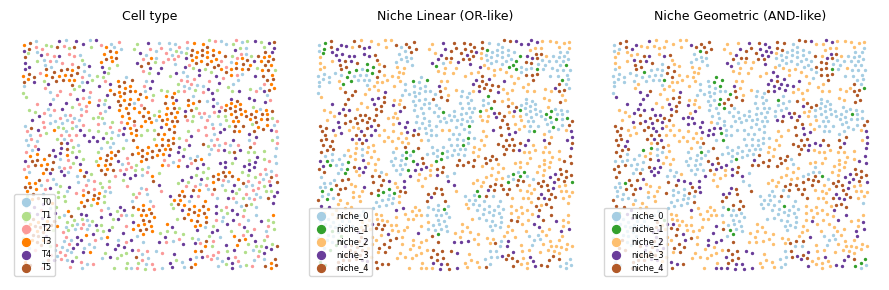

In [7]:
# Spatial maps — hard niche assignment per method
spatial_niche_grid(
    ad,
    score_cols=["cell_type", "niche_linear", "niche_geom"],
    titles=["Cell type", "Niche Linear (OR-like)", "Niche Geometric (AND-like)"],
    ncols=3,
)

### Geometric method: sharpening with `s_sharpen`

Raising $S$ to a power $\gamma > 1$ before column-normalisation concentrates
each niche profile on its dominant cell types, making the geometric score
progressively more exclusive:

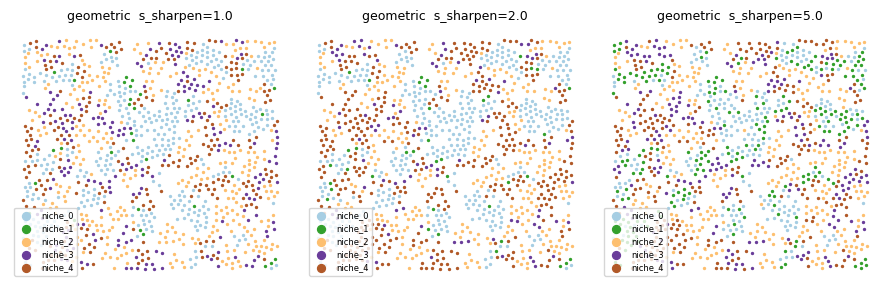

In [10]:
sharpen_values = [1.0, 2.0, 5.0]
sharpen_scores = {}

for gamma in sharpen_values:
    s = nf.cell_niche_scores(
        adjacency=ad.obsp["connectivities"],
        L=ad.obsm["cell_type_prob"],
        W=result.W,
        H=result.H,
        method="geometric",
        s_sharpen=gamma,
        cell_index=ad.obs_names,
        niche_names=niche_names,
    )
    sharpen_scores[gamma] = s
    ad.obs[f"niche_geom_s{gamma:.0f}"] = s.idxmax(axis=1).values

spatial_niche_grid(
    ad,
    score_cols=[f"niche_geom_s{g:.0f}" for g in sharpen_values],
    titles=[f"geometric  s_sharpen={g}" for g in sharpen_values],
    ncols=3,
)

## 3. Label Smoothing: `n_smooth_iter`

Hard niche labels (argmax of scores) can contain isolated cells whose label
differs from all their neighbours — artefacts rather than true niche
boundaries.

`n_smooth_iter` applies **conservative majority-vote smoothing** on the kNN
graph: a cell's label is flipped to the most prevalent neighbour label only
when that label's vote advantage exceeds `smooth_margin` (default `1.0`).
Setting `n_smooth_iter > 0` appends a `"niche_label"` column containing the
smoothed assignment to the returned DataFrame.

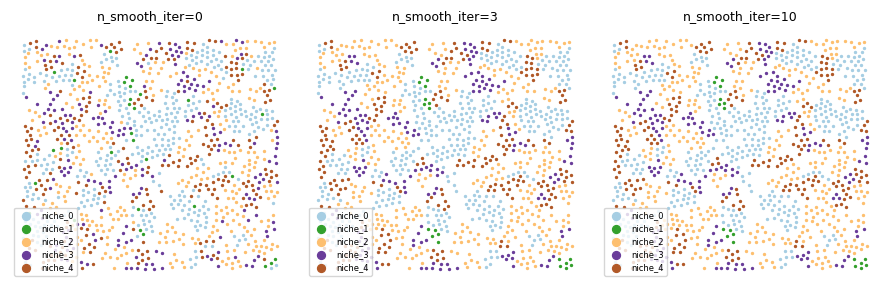

In [25]:
smooth_iter_values = [0, 3, 10]

for n_iter in smooth_iter_values:
    s = nf.cell_niche_scores(
        adjacency=ad.obsp["connectivities"],
        L=ad.obsm["cell_type_prob"],
        W=result.W,
        H=result.H,
        method="geometric",
        s_sharpen=1.0,
        n_smooth_iter=n_iter,
        smooth_margin=0.1,
        cell_index=ad.obs_names,
        niche_names=niche_names,
    )
    if n_iter == 0:
        ad.obs[f"niche_smooth_{n_iter}"] = s.idxmax(axis=1).values
    else:
        # n_smooth_iter > 0 appends a 'niche_label' column
        ad.obs[f"niche_smooth_{n_iter}"] = s["niche_label"].values

smooth_cols   = [f"niche_smooth_{n}" for n in smooth_iter_values]
smooth_titles = [f"n_smooth_iter={n}" for n in smooth_iter_values]
spatial_niche_grid(ad, score_cols=smooth_cols, titles=smooth_titles, ncols=3)

In [21]:
# How many cells changed label relative to the unsmoothed baseline?
base = ad.obs["niche_smooth_0"]
for n_iter in smooth_iter_values[1:]:
    smoothed = ad.obs[f"niche_smooth_{n_iter}"]
    n_changed = (smoothed != base).sum()
    print(f"n_smooth_iter={n_iter:2d}: {n_changed:4d} cells relabelled  "
          f"({100 * n_changed / ad.n_obs:.1f} %)")

n_smooth_iter= 3:  197 cells relabelled  (16.4 %)
n_smooth_iter=10:  197 cells relabelled  (16.4 %)


## Summary

### Choosing a scoring strategy

| Situation | Recommended setting |
|---|---|
| Default / most robust | `method="linear"`, `knn_mode="undirected"`, `alpha=0.5` |
| Niches require all cell types simultaneously | `method="geometric"` |
| Sharper niche boundaries with geometric | increase `s_sharpen` (e.g. `2`–`5`) |
| Noisy boundaries / salt-and-pepper labels | add `n_smooth_iter=2`–`10` |